In [1]:
# !pip install pysheds netCDF4 fiona geopandas xarray pyshp

In [2]:
# IMPORT PACKAGES
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import shapefile
import os

import netCDF4 as nc
from netCDF4 import Dataset
from shapely.geometry import Point, shape, box, mapping
from shapely.vectorized import contains
from shapely.strtree import STRtree

from rasterio.coords import BoundingBox
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import shapes

In [3]:
# DEFINE INPUTS FOR FUNCTION
masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_FINAL_REVISED.csv'

full_df = pd.read_csv(masterlist)
station_num = full_df['grdc_no']

print(f"Loaded {len(station_num)} stations.")

Loaded 553 stations.


In [4]:
# for i in range(0):
i = 0
data = full_df.iloc[i]
number = data['grdc_no']
region = data['wmo_reg']
river = data['river']
name = data['station']
lat = data['lat']
lon = data['long']
area = data['area']
altitude = data['altitude']
shp_log = data['shapefile_code']
print(shp_log)
# output_tif = f'/global/scratch/users/arvalcarcel/CSMUB/DATA/DEM/STATIONS/{number}_dem.tif'

1


In [5]:
# Read the shapefiles
shapefile1 = f'/global/home/users/arvalcarcel/ondemand/data/dem/{number}/{number}.shp' # delineated shapefile
shapefile2 = f'/global/scratch/users/arvalcarcel/CSMUB/DATA/SHAPEFILES/{number}/{number}.shp' # GRDC shapefile

if shp_log == 1:
    shapefile = shapefile1

elif shp_log == 2:
    shapefile = shapefile2

In [6]:
landcover_map = '/global/scratch/users/arvalcarcel/CSMUB/DATA/landcover_mosaic.tif'
gdf = gpd.read_file(shapefile)

# # Open the landcover raster
# with rasterio.open(landcover_map) as src:
#     raster_crs = src.crs
#     raster_bounds = src.bounds  # Get raster extent

# print(f"Raster CRS: {raster_crs}")
# print(f"Raster Bounds: {raster_bounds}")

# # Open the shapefile
# print(f"Shapefile CRS: {gdf.crs}")
# print(f"Shapefile Bounds: {gdf.total_bounds}")  # Get extent of shapefile

In [7]:
# File paths
geotiff_path = landcover_map

# Load shapefile
gdf = gpd.read_file(shapefile)

# Open the GeoTIFF
with rasterio.open(geotiff_path) as src:
    # Reproject shapefile to match raster CRS
    gdf = gdf.to_crs(src.crs)

    # Convert shapefile geometry to GeoJSON-like format
    shapes = [mapping(geom) for geom in gdf.geometry]

    # Mask raster with shapefile
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, filled=True)
    out_meta = src.meta.copy()

    # Update metadata
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

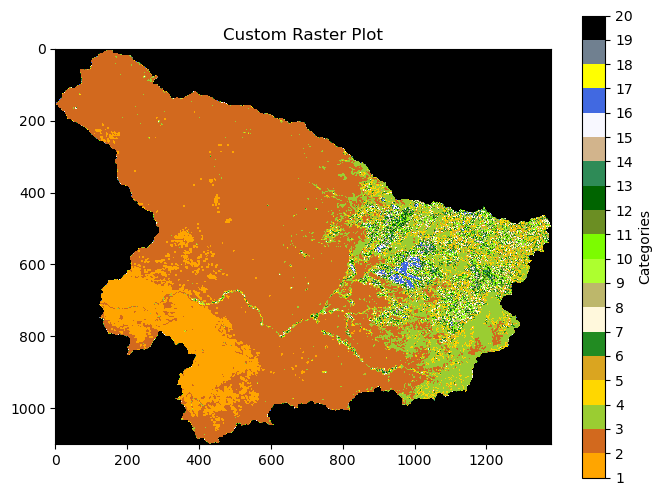

In [8]:
# Define the 20 colors (assuming a missing color, I duplicate 'black' at the end)
colors = [
    'orange', 'chocolate', 'yellowgreen', 'gold', 'goldenrod',
    'forestgreen', 'cornsilk', 'darkkhaki', 'greenyellow', 'lawngreen',
    'olivedrab', 'darkgreen', 'seagreen', 'tan', 'ghostwhite',
    'royalblue', 'yellow', 'slategray', 'navy', 'black' 
]

# Create colormap and norm
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(1, 21), cmap.N)  # Bins for values 1-20

# Assume `out_image[0]` is your raster data with values between 1-20
fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(out_image[0], cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax, ticks=np.arange(1, 21))
cbar.set_label("Categories")

plt.title("Custom Raster Plot")
plt.show()

In [13]:
# Flatten the masked array and remove nodata values
# Masked array: out_image is (1, height, width) with nodata masked
masked_array = np.ma.masked_array(out_image, out_image == src.nodata)

# Alternatively, use the mask from the output:
valid_pixels = masked_array.compressed()


# Count occurrences of each band value (1-20)
unique, counts = np.unique(valid_pixels, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Compute percentage of total valid pixels
total_pixels = valid_pixels.size
percentages = {i: (pixel_counts[i] / total_pixels * 100) if i in pixel_counts else 0 for i in range(1, 21)}

# Convert to DataFrame
df_landcover = pd.DataFrame([percentages])
print(df_landcover)
# print(df_landcover.sum(axis=1))

         1          2          3        4         5         6         7   \
0  6.136561  60.524866  17.803458  3.55448  1.860924  1.402201  1.166174   

         8         9        10        11        12        13        14  \
0  0.984093  0.847784  0.78491  0.725055  0.678026  0.634266  0.625967   

         15        16       17        18  19  20  
0  0.632506  0.746809  0.80591  0.086011   0   0  


In [10]:
# results_csv = f"/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/LANDCOVER/{number}.csv"
# df_landcover.to_csv(results_csv, index=False)
# print(pd.read_csv(results_csv))